# **Beijing Air Quality Forecasting Data Visualizations Notebook**

This notebook contains the data visualizations and analysis done during the Exploratory Data Analysis stage.


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir '/content/data'
!unzip -qo 'assignment-1-time-series-forecasting-may-2025.zip' -d '/content/data'

assignment-1-time-series-forecasting-may-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘/content/data’: File exists


#### Libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

## Data Exploration, Preprocessing and Feature Engineering

### Data Exploration

In [ ]:
# load data
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/test.csv')

# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13148 entries, 0 to 13147
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        13148 non-null  int64  
 1   DEWP      13148 non-null  float64
 2   TEMP      13148 non-null  float64
 3   PRES      13148 non-null  float64
 4   Iws       13148 non-null  float64
 5   Is        13148 non-null  float64
 6   Ir        13148 non-null  float64
 7   datetime  13148 non-null  object 
 8   cbwd_NW   13148 non-null  float64
 9   cbwd_SE   13148 non-null  float64
 10  cbwd_cv   13148 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.1+ MB
None


In [ ]:
test.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [ ]:
# get the summary info of tthe training df
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
None


In [ ]:
# get data statistics
print(train.describe())

                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.018337   
min        1.000000     -2.135153     -2.578070     -2.380821     -0.468688   
25%     7669.750000     -0.888034     -0.938521     -0.822670     -0.441894   
50%    15338.500000     -0.056622      0.045209     -0.043595     -0.352512   
75%    23007.250000      0.913358      0.864984      0.832865      0.005216   
max    30676.000000      1.814055      2.340578      2.877939     11.231956   

                 Is            Ir       cbwd_NW       cbwd_SE       cbwd_cv  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean       0.016992      0.011253      0.016193      0.005833     -0.025008   
std        1.087278      1.063811      1.006001    

#### **Train Data Statistsics**

Most features have mean values close to zero and standard deviations around 1, suggesting they have been standardized.


We see a distinction in the features:
 **Meteorological Variables** -
 1. DEWP (Dew Point)
 2. TEMP (Temperature)
 3. PRES (Pressure)
 4. Iws (Wind Speed)
 5. Is and Ir (Potentially Solar Irradiance / Other Meteorological Factors)

 **Categorical Wind Direction Variables**:
 cbwd_NW, cbwd_SE, cbwd_cv

 - These appear to be encoded binary variables (scaled versions of categorical values).

- Range: Negative to positive values indicate standardized encoding, possibly from one-hot/dummy transformations.

- Interpretation: Different wind directions influencing pollution transport.

**Target Variable: PM2.5 Concentration**
- Mean: 100.79 - Suggests moderately high pollution levels overall.

- Standard Deviation: 93.14 - High variability, meaning pollution fluctuates significantly.

- Min: 0.0, Max: 994.0 - There are periods of completely clean air and extreme pollution events.

- Quartiles (Q1=29, Median=75, Q3=142):

- Lower 25% of values indicate mild pollution (~29).

- Upper 25% reach substantial pollution (~142).

- Extreme Max Value (994) suggests rare but severe pollution spikes.

In [ ]:
# identify columns wiht missing values
print(train.isnull().sum())

No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


#### **Visualizing the distributions of key (meterorological) variables**

- Tis will help in understanding the **trend, seasonality and residual** components, to understand how pollution levels evolve over time

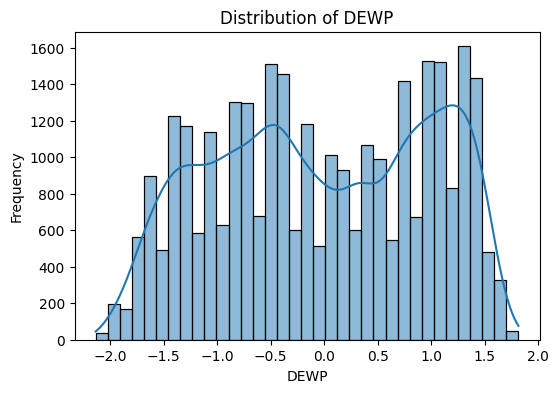

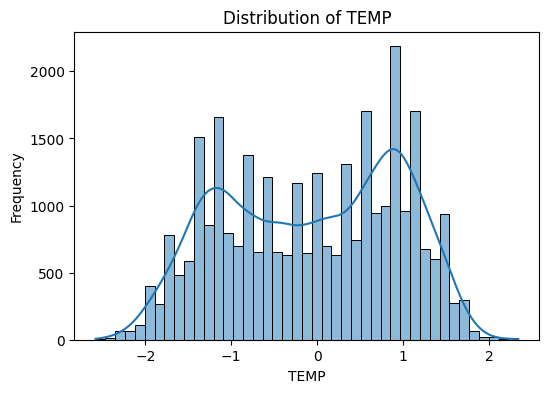

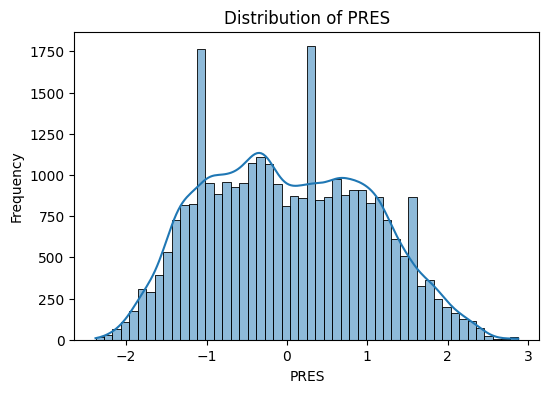

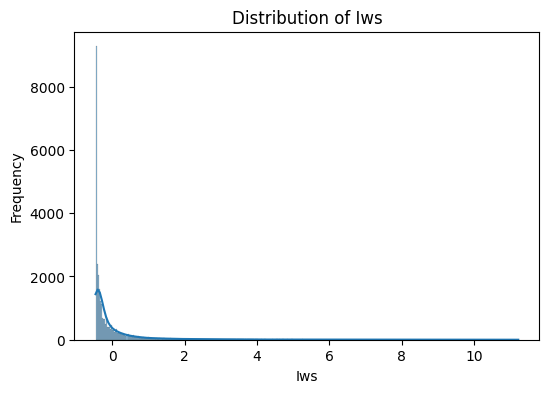

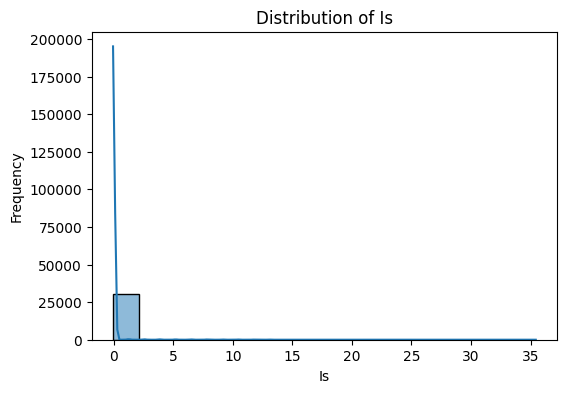

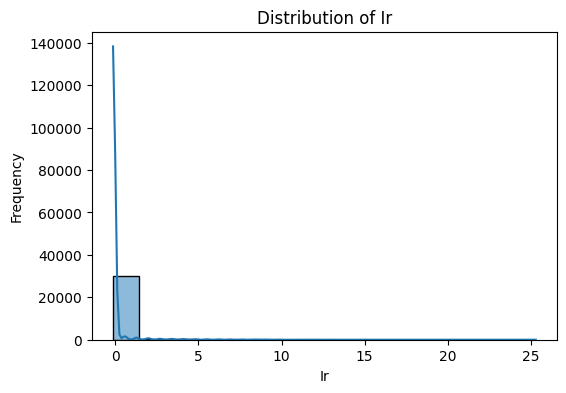

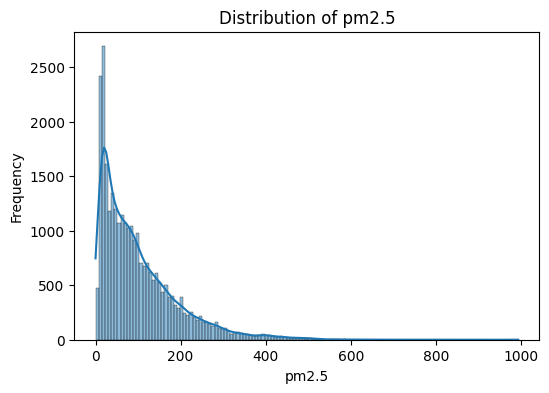

In [ ]:
# visualizing the distribution of key variables

features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
for feature in features:
  plt.figure(figsize=(6,4))
  sns.histplot(train[feature].dropna(), kde=True)
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.show()

#### **Decomposition**

From the previous visualizations, we now investigate the target variable pm2.5 to see its patterns over time.

1. Trend Component:

- This shows the long-term movement of PM2.5 levels from January 2010 to July 2013.

- The trend fluctuates between approximately 50 and 300, indicating notable variations over time.

- If there's a persistent increase, it could suggest worsening air quality over the years.

2. Seasonal Component:

- Displays repeating patterns within a weekly cycle (since the period was set to 24*7).

- The values oscillate between -15 and 10, suggesting systematic fluctuations in PM2.5 levels throughout the week.

- Peaks and troughs indicate specific days where pollution tends to rise or fall—possibly linked to traffic patterns or meteorological effects.

3. Residual Component:

- Represents noise or irregular variations that are not captured by trend or seasonality.

- The residual values range from -200 to 800, indicating occasional extreme spikes in pollution that cannot be explained by systematic patterns alone.

- If large outliers appear, they may indicate abrupt pollution events such as industrial emissions or weather anomalies.

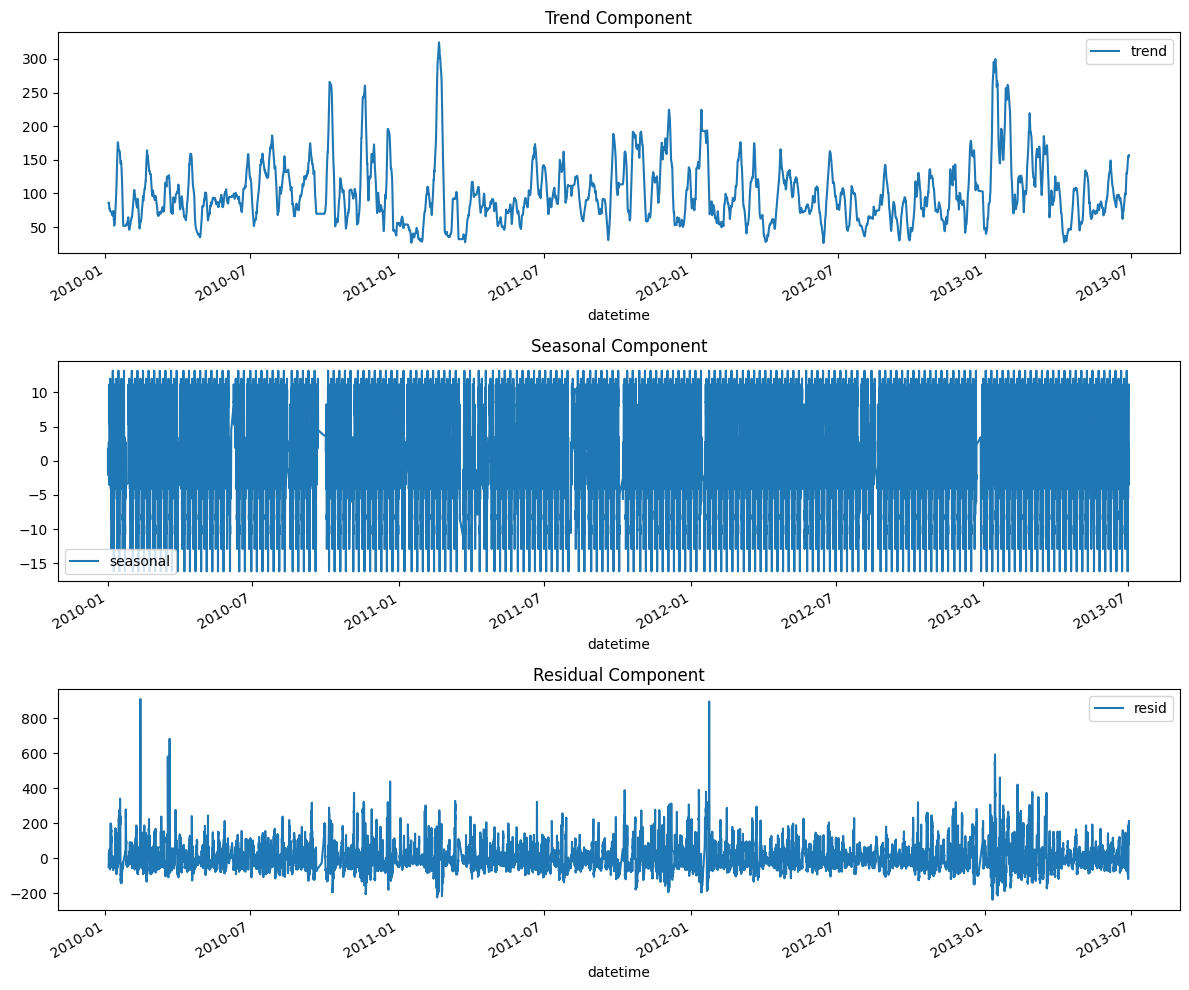

In [ ]:
# ensure datetime is in pandas datetime format
# Check if 'datetime' is a column before processing
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'])
    train.set_index('datetime', inplace=True)

# decompose
pm_25 = train['pm2.5'].dropna() #drop missing values from pm2.5
period = 24*7 #define seasonal period
result = seasonal_decompose(pm_25, model='additive', period=period)

# plot
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
result.trend.plot(ax=axs[0], title='Trend Component', legend=True)
result.seasonal.plot(ax=axs[1], title='Seasonal Component', legend=True)
result.resid.plot(ax=axs[2], title='Residual Component', legend=True)
plt.tight_layout()
plt.show()

#### **Distribution of PM2.5 values by the hour**

Hour-to-Hour Variation: Each box plot corresponds to a specific hour of the day (extracted and stored in the hour column). By comparing boxes across different hours, you can observe if:

- Certain hours consistently have higher or lower median PM2.5.

- Some hours show a larger spread, indicating that PM2.5 levels are more variable at those times.

Patterns in Variability:

- A consistently high median or a large box at certain hours may suggest recurring factors (like rush hours or industrial activities) affecting pollutant levels.

- Consistent low variability (a small IQR) might indicate stable conditions during that hour.

Identification of Outliers:

- Outliers can signal occasional abnormal events, perhaps due to weather shifts, sudden vehicular emissions, or other environmental events.

- Those outliers could be just noise, or they may be important signals warranting further investigation.

From these insights, you can start to hypothesize:

- Air Quality Dynamics: Which hours are most polluted and why, possibly linking them to human activities or meteorological conditions.

- Feature Engineering for Forecasting: You might decide to give more weight or create dedicated features for those hours that display significant variability.

<Axes: title={'center': 'pm2.5'}, xlabel='hour'>

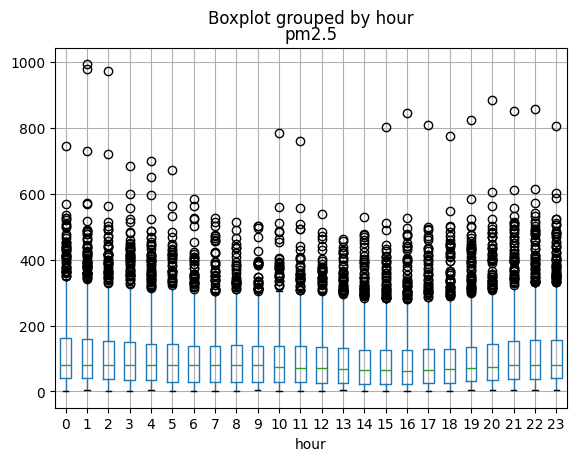

In [ ]:
train['hour'] = train.index.hour
train.boxplot(column='pm2.5', by='hour')

#### **Autocorrelation and Partial Autocorrelation**

**Autocorrelation**

The ACF (autocorrelation function) plot gives you a visual summary of how the PM2.5 values relate to their past values (lagged observations).

- Strong short-term autocorrelation: The plot shows high correlation for the first few lags (e.g., lag 1, lag 2), meaning that PM2.5 concentrations are influenced by the immediate past values.

- Possible daily seasonality: If you observe spikes or an uptick in correlation at around lag 24 (or its multiples), this indicates a daily cycle in the data.

- Memory effect: A slowly decaying autocorrelation function tells you that even values several hours in the past have some influence on the current PM2.5 levels.


**Partial Autocorrelation**

- Significant Lags
Look at the first few lags.
High spikes at Lag 1 or Lag 2, it suggests PM2.5 is strongly dependent on the immediate previous values.

- Seasonal Influence
If there are spikes around Lag 24 (or multiples like 48, 72), this suggests daily periodic effects.

- Confidence Bounds
Bars above the significance threshold (usually shown as shaded regions or horizontal lines) indicate statistically significant partial autocorrelations.

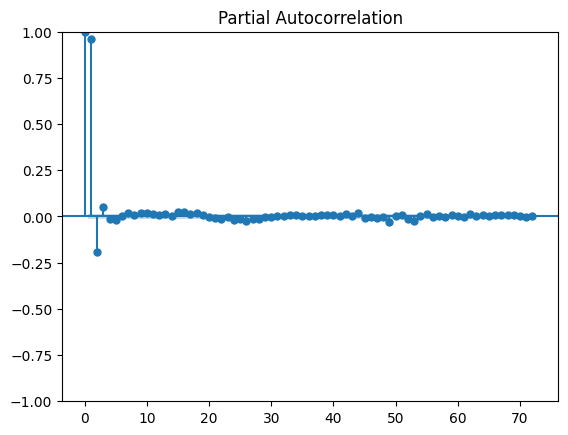

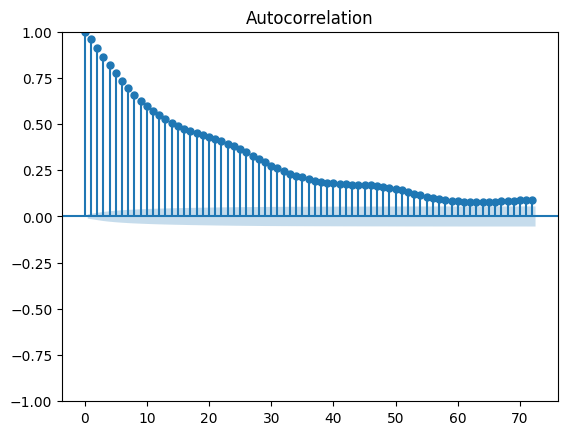

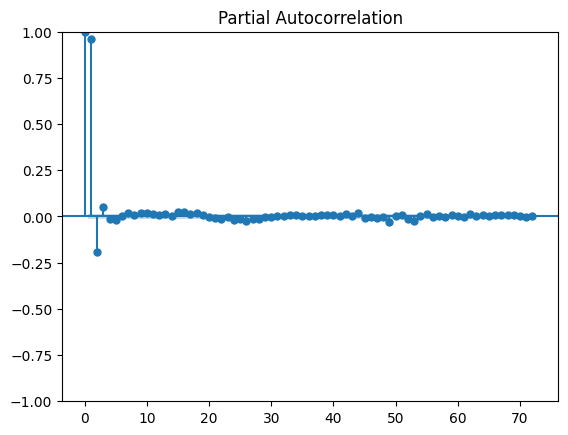

In [ ]:
plot_acf(train['pm2.5'].dropna(), lags=72)
plot_pacf(train['pm2.5'].dropna(), lags=72)

#### **Correlation Heatmap between key features**

PM2.5 vs. TEMP:

- If positively correlated, warmer temperatures might be linked to higher pollution levels (due to atmospheric reactions).

- If negatively correlated, colder temperatures might trap pollutants near the surface.

PM2.5 vs. Wind Speed (Iws):

- A negative correlation would suggest that stronger winds help disperse pollutants.

- A weak correlation might indicate that wind speed alone is not a major factor.

PM2.5 vs. Pressure (PRES):

- Typically negative, meaning higher pressure leads to clearer air conditions.

- Lower pressure might trap pollutants, increasing PM2.5 levels.

<Axes: >

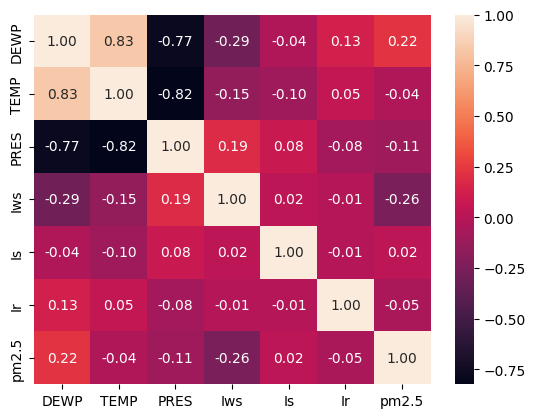

In [ ]:
corr = train[['DEWP','TEMP','PRES','Iws','Is','Ir','pm2.5']].corr()
sns.heatmap(corr, annot=True, fmt=".2f")

#### **Cross-Correlation between key variables and PM2.5**

- CCF bars (lags 0–47) for each feature vs. PM2.5:

- TEMP leads PM2.5 by ~2–4 hours (negative correlation);

- DEWP shows positive lead up to 6 hours;

- Wind speed (Iws) shows negative correlation at short lags, indicating dispersion effects.Insight: The lagged influences reinforce using sequential models to learn temporal dependencies.

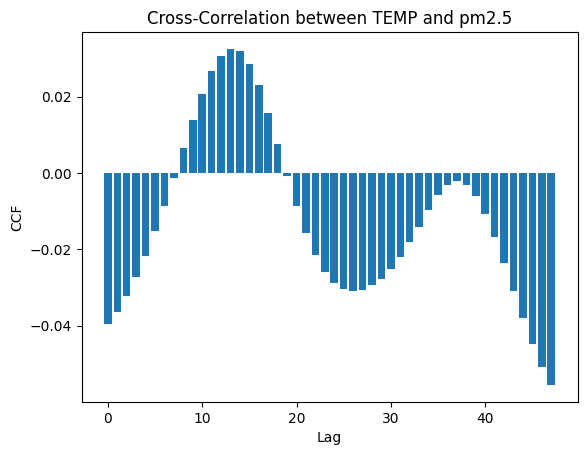

In [ ]:
temp_pm25_data = train[['TEMP', 'pm2.5']].dropna()
ccf_vals = ccf(temp_pm25_data['TEMP'], temp_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between TEMP and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

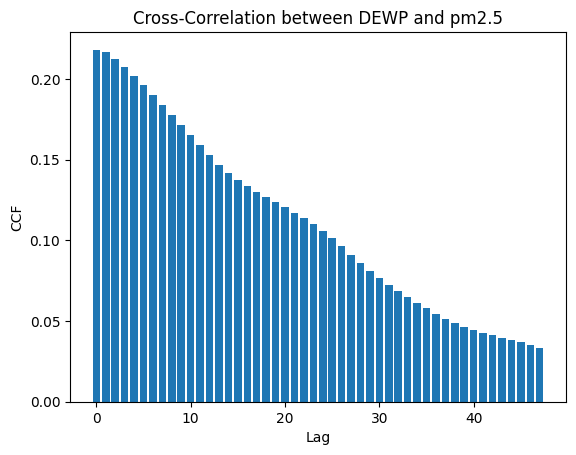

In [ ]:
dewp_pm25_data = train[['DEWP', 'pm2.5']].dropna()
ccf_vals = ccf(dewp_pm25_data['DEWP'], dewp_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between DEWP and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

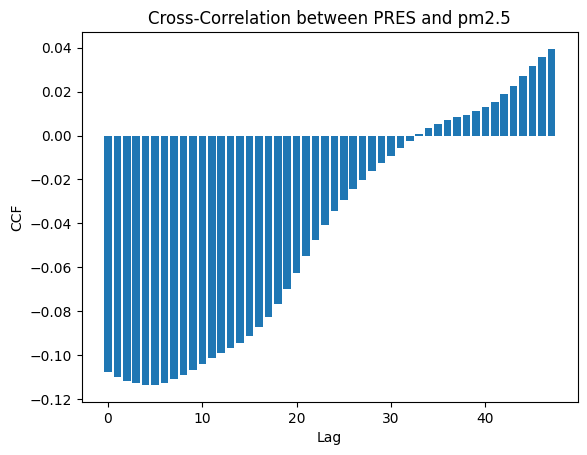

In [ ]:
pres_pm25_data = train[['PRES', 'pm2.5']].dropna()
ccf_vals = ccf(pres_pm25_data['PRES'], pres_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between PRES and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

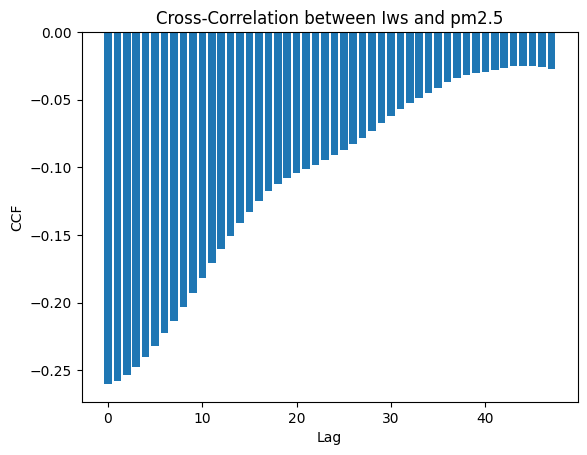

In [ ]:
iws_pm25_data = train[['Iws', 'pm2.5']].dropna()
ccf_vals = ccf(iws_pm25_data['Iws'], iws_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between Iws and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

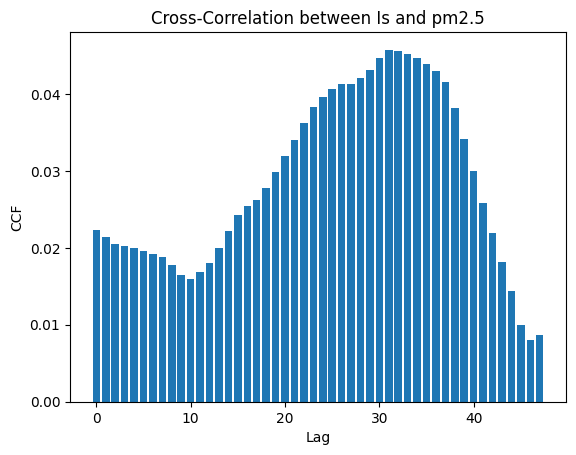

In [ ]:
is_pm25_data = train[['Is', 'pm2.5']].dropna()
ccf_vals = ccf(is_pm25_data['Is'], is_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between Is and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

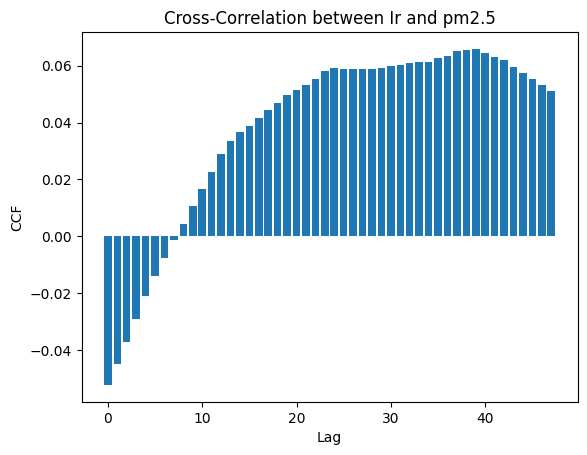

In [ ]:
ir_pm25_data = train[['Ir', 'pm2.5']].dropna()
ccf_vals = ccf(ir_pm25_data['Ir'], ir_pm25_data['pm2.5'])[:48]

plt.bar(range(48), ccf_vals)
plt.title('Cross-Correlation between Ir and pm2.5')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

#### **Missing PM.25 values over time**

This bar plot visualizes the monthly count of missing PM2.5 values, helping us identify patterns in missing data over time.

- Monthly missing PM2.5 counts bar chart reveals that missingness clusters in colder months
- Insight:interpolation within rolling windows of similar weather ensures realistic imputation and avoids biasing models toward seasonal gap

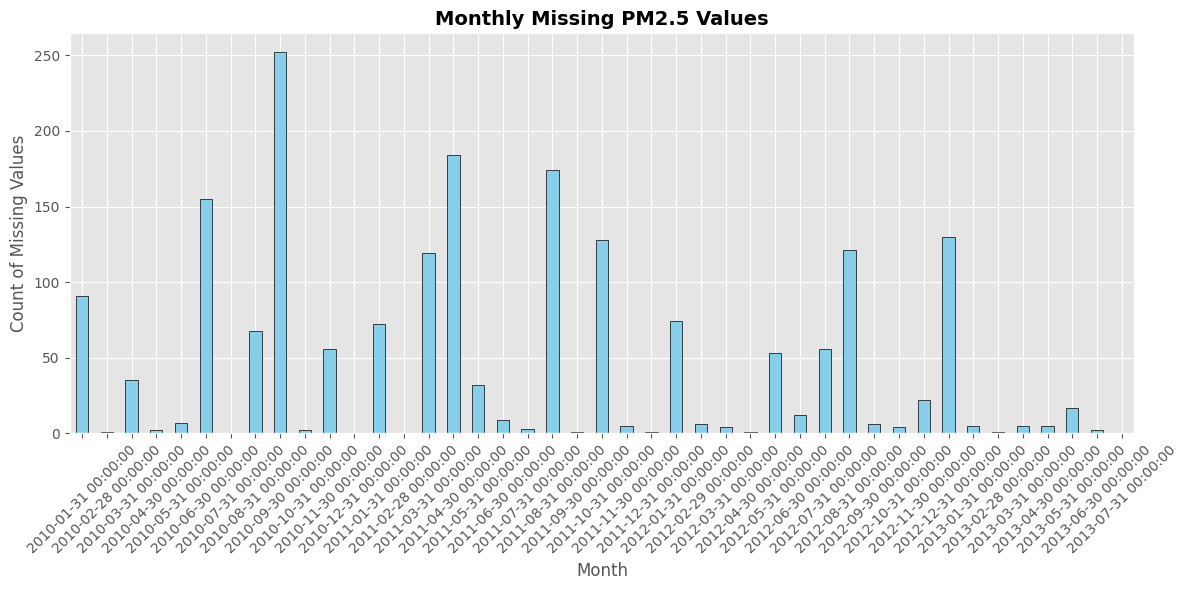

In [ ]:
# plot missing values over time
missing_pm25 = train['pm2.5'].isnull().resample('ME').sum()

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
missing_pm25.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Missing Values', fontsize=12)
plt.title('Monthly Missing PM2.5 Values', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **Stationarity Test**
I ran the ADF stationarity test on PM2.5 values to determine whether the time series is stationary (i.e., whether its statistical properties remain constant over time).

- p-value: 7.73e-30 (almost 0)

- Since the p-value is extremely small (< 0.05), it confirms that the PM2.5 series is stationary.

- A low p-value indicates that changes in PM2.5 do not follow a trend but instead fluctuate around a constant mean and variance.
- From the results, PM2.5 is stationary, meaning it does not exhibit a strong trend or seasonality requiring differencing before time series modeling

In [ ]:
# stationarity test
adfuller(train['pm2.5'].dropna())

(np.float64(-17.07856301377727),
 np.float64(7.735678097632149e-30),
 48,
 28706,
 {'1%': np.float64(-3.4305778229238553),
  '5%': np.float64(-2.8616406914075068),
  '10%': np.float64(-2.566823594992479)},
 np.float64(266200.15637746494))

**Wind direction Encoding**
- Each feature has two distinct values, meaning these columns were likely binary-encoded.

- They were standardized (not just 0 and 1), as seen from their negative and positive values.

- These are transformed categorical variables, representing wind direction in a way that numerical models can process effectively.


In [ ]:
print("cbwd_NW unique values:")
print(train['cbwd_NW'].unique())

print("\ncbwd_SE unique values:")
print(train['cbwd_SE'].unique())

print("\ncbwd_cv unique values:")
print(train['cbwd_cv'].unique())


cbwd_NW unique values:
[ 1.44813759 -0.69054212]

cbwd_SE unique values:
[-0.7320191   1.36608457]

cbwd_cv unique values:
[-0.52209647  1.91535485]
